In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import lime
from lime.lime_tabular import LimeTabularExplainer

# Data Loading with Augmentation
base_path = '../Database/'
data, labels = [], []

data_gen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    brightness_range=[0.8, 1.2], fill_mode='nearest'
)

# Load Data
def load_images_from_folder(folder, label):
    folder_path = os.path.join(base_path, folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        data.append(img)
        labels.append(label)

load_images_from_folder("Normal", "Normal")
for folder in ["Lung_Opacity", "Viral Pneumonia"]:
    load_images_from_folder(folder, "Lung_Disease")

data = np.array(data).astype('float32') / 255.0
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Extract HOG Features
def extract_hog_features(images):
    return np.array([hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=False) for img in images])

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Combine CNN + HOG Features
X_train_combined = np.hstack((X_train.reshape(X_train.shape[0], -1), X_train_hog))
X_test_combined = np.hstack((X_test.reshape(X_test.shape[0], -1), X_test_hog))

# Handle Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_train_combined, y_train = smote.fit_resample(X_train_combined, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

# Custom Dense Model (for combined features)
def create_custom_dense_model(input_shape):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model Initialization
model = create_custom_dense_model(X_train_combined.shape[1])

# Learning Rate Scheduler & Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_combined, y_train, validation_data=(X_test_combined, y_test),
                    epochs=50, callbacks=[lr_scheduler, early_stopping], batch_size=32)

# Evaluation
y_pred = (model.predict(X_test_combined) > 0.55).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# LIME Explanation
# Modify LIME explanation
explainer = LimeTabularExplainer(
    X_train_combined,
    feature_names=["Feature " + str(i) for i in range(X_train_combined.shape[1])],
    class_names=["Normal", "Lung_Disease"],
    discretize_continuous=True
)

# Function to make LIME-compatible predictions
def lime_predict_fn(x):
    preds = model.predict(x)  # Model returns shape (n_samples, 1)
    return np.hstack([1 - preds, preds])  # Convert to shape (n_samples, 2)

# Explain a test instance
exp = explainer.explain_instance(X_test_combined[0], lime_predict_fn, num_features=10)

# Show explanation
exp.as_pyplot_figure()
plt.show()

# Plot Training & Validation Graphs
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)


C:\Users\thebe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.6739 - loss: 0.6949 - val_accuracy: 0.8496 - val_loss: 0.4198 - learning_rate: 5.0000e-04
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.7982 - loss: 0.4557 - val_accuracy: 0.8586 - val_loss: 0.3521 - learning_rate: 5.0000e-04
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.8355 - loss: 0.3872 - val_accuracy: 0.8752 - val_loss: 0.3053 - learning_rate: 5.0000e-04
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.8488 - loss: 0.3398 - val_accuracy: 0.8812 - val_loss: 0.2893 - learning_rate: 5.0000e-04
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.8660 - loss: 0.3315 - val_accuracy: 0.8887 - val_loss: 0.2603 - learning_rate: 5.0000e-04
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.8974 - loss: 0.2582 - val_accuracy: 0.8992 - val_loss: 0.2608 - learning_rate: 5.0000e-04
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 141m

KeyboardInterrupt: 

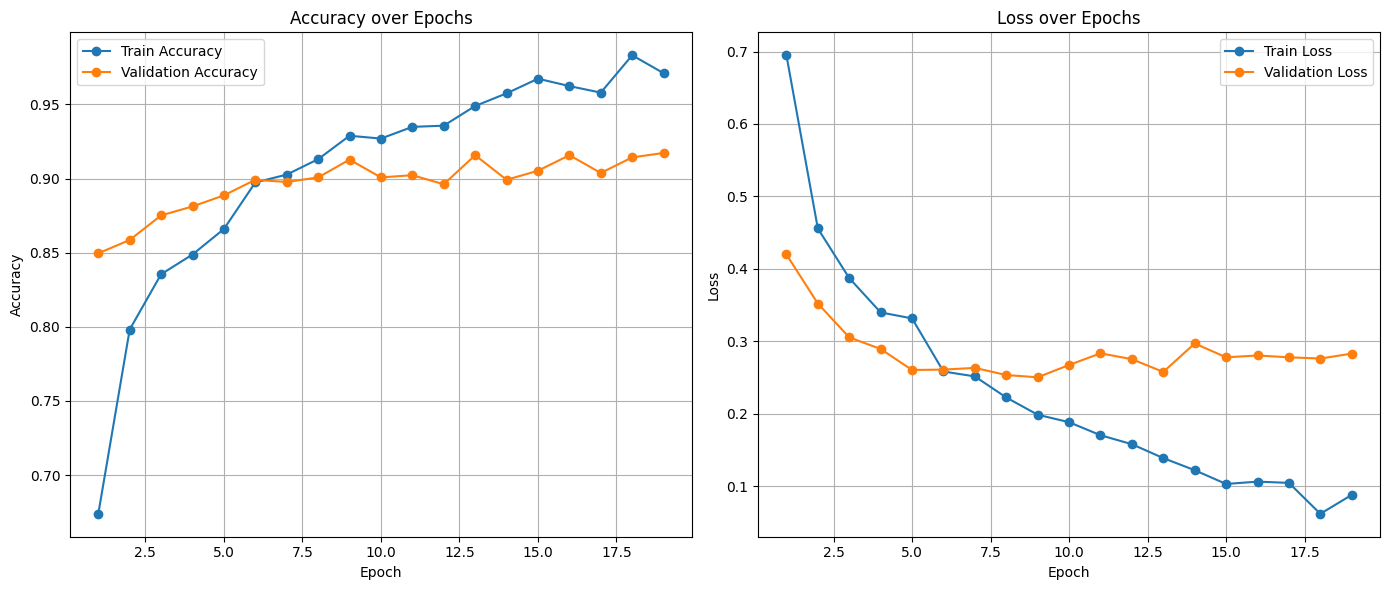

In [4]:
import matplotlib.pyplot as plt

# Epoch data
epochs = list(range(1, 20))
train_accuracy = [0.6739, 0.7982, 0.8355, 0.8488, 0.8660, 0.8974, 0.9027, 0.9131, 0.9289, 0.9270,
                  0.9349, 0.9357, 0.9490, 0.9575, 0.9674, 0.9624, 0.9580, 0.9832, 0.9711]
val_accuracy = [0.8496, 0.8586, 0.8752, 0.8812, 0.8887, 0.8992, 0.8977, 0.9008, 0.9128, 0.9008,
                0.9023, 0.8962, 0.9158, 0.8992, 0.9053, 0.9158, 0.9038, 0.9143, 0.9173]
train_loss = [0.6949, 0.4557, 0.3872, 0.3398, 0.3315, 0.2582, 0.2514, 0.2223, 0.1985, 0.1882,
              0.1702, 0.1578, 0.1386, 0.1219, 0.1029, 0.1061, 0.1044, 0.0617, 0.0878]
val_loss = [0.4198, 0.3521, 0.3053, 0.2893, 0.2603, 0.2608, 0.2632, 0.2533, 0.2502, 0.2672,
            0.2833, 0.2752, 0.2576, 0.2969, 0.2778, 0.2803, 0.2778, 0.2761, 0.2829]

# Plot accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
